run this in console to prevent colab from disconnecting:


```
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```



In [ ]:
i = []
while True:
  i.append(i)

In [ ]:
#Created by Ron Freeman 2021. All rights reserved.

import numpy as np
import scipy.signal as sig
from tqdm import tqdm
import scipy.optimize as opt
from functools import partial
import logging
import scipy

#general class to store information about a signal, hopefully cleans up the code
#also I wanted to try OOP
class Wave:
  def __init__(self, samples, fs):
    self.samples = samples
    self.fs = fs
    self.dur = len(samples)/fs
    self.t_index = np.linspace(0, len(samples)/fs, len(samples))
    self.psd = np.sum(abs(samples)**2)/len(samples)
  #  self.t_index = np.r_[0:len(samples)/fs:1]/fs #slightly more comfortable with doing it the way above but I've done the r_ method before


#this function returns the pearson correlation coefficient for the input signal and a locally generated signal with the given 
#tof and tag delay parameters
def findCor(rx_sig, tx_sig, tag_sig, tof, tag_delay):
  ideal_rx = combineTagnTxFFT(tag_sig, tx_sig, rx_sig.fs, tof, tag_delay)
  #return np.abs(np.corrcoef(rx_sig.samples, ideal_rx.samples, rowvar=False)[1,0]) #this does the sam thing as np.dot just normalized and a lot slower
  return np.abs(np.dot(rx_sig.samples, ideal_rx.samples))


def spacing(center, values):
  increment = center/(values/2)
  start = center-increment*(values/2)
  stop = center+increment*(values/2)
  return np.arange(start, stop+increment, increment)

#uses recursive search to find tof delay of signal
def findDelay3(rx_sig, tx_sig, tag_sig, tof_min, tof_max, tag_min, tag_max, it, max_it):
  if (it > max_it):
    return [(tof_min, tof_max), (tag_min, tag_max)]
  if (it == 0):
    tag_inc = 4096*2 #best 4096*2+1000
    tof_inc = 17 #best 17
  else:
    tag_inc = 19 #best 19
    tof_inc = 16 #best 16
  tof_pos_ar = np.linspace(tof_min, tof_max, tof_inc)
  tag_pos_ar = np.linspace(tag_min, tag_max, tag_inc)
  max_cor = 0
  for i, tof_pos in enumerate(tof_pos_ar):
    for j, tag_pos in enumerate(tag_pos_ar):
      cor = findCor(rx_sig, tx_sig, tag_sig, tof_pos, tag_pos)
      if cor > max_cor:
        max_cor = cor
        max_tof = i
        max_tag = j
  i = max_tof
  j = max_tag
  if j < 1:
    j += 1
  if i <1:
    i += 1
  if j == (tag_inc-1):
    j -= 1
  if i == (tof_inc-1):
    i -= 1
  return findDelay3(rx_sig, tx_sig, tag_sig, tof_pos_ar[i-1], tof_pos_ar[i+1], tag_pos_ar[j-1], tag_pos_ar[j+1], it+1, max_it)
  

#uses the fft method to add an arbitrary delay to a signal
def fracDelayfft(delay, wave):
  tend = wave.dur
  tstart = 0
  tDelay = delay
  samples = len(wave.samples)
  # 0. Example waveform to demonstrate the time shift
  timeList = np.linspace(0, wave.dur, len(wave.samples))
  waveform = wave.samples

  # 1. Take the FFT
  fftData = np.fft.fft(waveform)

  # 2. Construct the phase shift
  samplePeriod = (tend - tstart) / (samples)
  tDelayInSamples = tDelay / samplePeriod
  N = fftData.shape[0]
  k = np.linspace(0, N-1, N)
  timeDelayPhaseShift = np.exp(((-2*np.pi*1j*k*tDelayInSamples)/(N)) + (tDelayInSamples*np.pi*1j))

  # 3. Do the fftshift on the phase shift coefficients
  timeDelayPhaseShift = np.fft.fftshift(timeDelayPhaseShift)

  # 4. Multiply the fft data with the coefficients to apply the time shift
  fftWithDelay = np.multiply(fftData, timeDelayPhaseShift)

  # 5. Do the IFFT
  return np.fft.ifft(fftWithDelay)

#generates simulated signal incident at reciever for any given tag pattern and transmitted signal. This also adds noise to set a given snr for the signal.
def combineTagnTxNoiseFFT(tag_sig_, tx_sig_, Fs, tof, tag_offset, SNRlin): #assumes tof equal in both directions and that tx sig is longer than tag sig, also assumes delays are small relative to the length of the signal

  Fs_tx = tx_sig_.fs
  Fs_tag = tag_sig_.fs
  tx_sig = tx_sig_.samples
  tag_sig = tag_sig_.samples
  #to apply the delays a fractional delay filter might be more efficient but this method allows for a more arbitrary delay
  #a TODO is to implement a fractional delay filter with also a finite sample delay to get the same arbitrary delay but hopefully keep code cleaner and increase delay precision 
  #resample signals
  if not Fs == Fs_tx:
    #tx_sig = sincInterp(tx_sig, Fs_tx, Fs)
    tx_sig = sig.resample(tx_sig, int(Fs*tx_sig_.dur))
  #resample signals
  if not Fs == Fs_tag:
    #tag_sig = sincInterp(tag_sig, Fs_tag, Fs)
    tag_sig = sig.resample(tag_sig, int(Fs*tag_sig_.dur))
  #apply delays and figure out the emitted tag signal)
  tx_sig_delayed = fracDelayfft(tof, Wave(tx_sig, Fs))
  tag_sig_delayed = fracDelayfft(tag_offset, Wave(tag_sig, Fs))
  tiled_tag_sig = np.tile(tag_sig_delayed, int(np.floor(len(tx_sig_delayed)/len(tag_sig_delayed))))
  tag_sig_full = np.concatenate((tiled_tag_sig, tag_sig_delayed[:(len(tx_sig_delayed)-len(tiled_tag_sig))]))
  returning_sig_mult = (tx_sig_delayed)*tag_sig_full #element wise multiplication is the best approximation
  incident_tag_sig = Wave(returning_sig_mult, Fs)
  #adding noise with given SNR
  N = len(incident_tag_sig.samples)
  noise_rand = np.random.randn(N)
  noise_psd = incident_tag_sig.psd/SNRlin
  noise = np.sqrt(noise_psd/2)*noise_rand 
  #apply returning tof
  incident_tag_sig.samples = incident_tag_sig.samples+noise
  incident_tag_sig.samples = fracDelayfft(tof, incident_tag_sig)

  #return both emitted tag signal and incident signal to the receiver
  returning_sig_delayed = Wave(incident_tag_sig.samples, Fs)
  #adding noise with given SNR
  N = len(returning_sig_delayed.samples)
  noise_rand = np.random.randn(N)
  noise_psd = returning_sig_delayed.psd/SNRlin
  noise = np.sqrt(noise_psd/2)*noise_rand 
  returning_sig_delayed_noise = Wave(returning_sig_delayed.samples+noise, Fs)
  return returning_sig_delayed_noise

#generates simulated signal incident at reciever for any given tag pattern and transmitted signal.
def combineTagnTxFFT(tag_sig_, tx_sig_, Fs, tof, tag_offset): #assumes tof equal in both directions and that tx sig is longer than tag sig, also assumes delays are small relative to the length of the signal

  Fs_tx = tx_sig_.fs
  Fs_tag = tag_sig_.fs
  tx_sig = tx_sig_.samples
  tag_sig = tag_sig_.samples
  #to apply the delays a fractional delay filter might be more efficient but this method allows for a more arbitrary delay
  #a TODO is to implement a fractional delay filter with also a finite sample delay to get the same arbitrary delay but hopefully keep code cleaner and increase delay precision 
  #resample signals
  if not Fs == Fs_tx:
    #tx_sig = sincInterp(tx_sig, Fs_tx, Fs)
    tx_sig = sig.resample(tx_sig, int(Fs*tx_sig_.dur))
  #resample signals
  if not Fs == Fs_tag:
    #tag_sig = sincInterp(tag_sig, Fs_tag, Fs)
    tag_sig = sig.resample(tag_sig, int(Fs*tag_sig_.dur))
  #apply delays and figure out the emitted tag signal)
  tx_sig_delayed = fracDelayfft(tof, Wave(tx_sig, Fs))
  tag_sig_delayed = fracDelayfft(tag_offset, Wave(tag_sig, Fs))
  tiled_tag_sig = np.tile(tag_sig_delayed, int(len(tx_sig_delayed)/len(tag_sig_delayed)))
  tag_sig_full = np.concatenate((tiled_tag_sig, tag_sig_delayed[:(len(tx_sig_delayed)-len(tiled_tag_sig))]))
  returning_sig_mult = (tx_sig_delayed)*tag_sig_full #element wise multiplication is the best approximation
  incident_tag_sig = Wave(returning_sig_mult, Fs)

  #apply returning tof
  incident_tag_sig.samples = incident_tag_sig.samples
  incident_tag_sig.samples = fracDelayfft(tof, incident_tag_sig)

  #return both emitted tag signal and incident signal to the receiver
  returning_sig_delayed = Wave(incident_tag_sig.samples, Fs)
  return returning_sig_delayed

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time




def eval(noise_pow=0.1e-3, listen_time=10*60*60, dB_FSPL=61, Fs_tx=200e+3, tag_switch_width=1e-4):
  error_sum = 0
  error_res = []
  pre_snr = []
  post_snr = []
  #tx signal
  f0 = 1e+3
  Tx_dt = 40.96e-3 #Tx random num sequence duration in seconds, nSymbols needs to be below 16777215
  sps = 100
  for k in range(10):
    n_TxSymbol = int((Fs_tx*Tx_dt)/sps)
    num_samples = n_TxSymbol*sps
    #create wave object
    tx_sig_raw = np.random.normal(loc=0, scale=np.sqrt(10), size=num_samples)

    """
    #LPF with cutoff at 100 khz
    fH = 0.75  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
    b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1  # Make sure that N is odd.
    n = np.arange(N)
    
    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (n - (N - 1) / 2))
    hlpf *= np.blackman(N)
    hlpf = hlpf / np.sum(hlpf)

    tx_sig_raw = sig.convolve(tx_sig_raw, hlpf)
    """

    tx_sig = Wave(tx_sig_raw, Fs_tx)
    tx_sig_raw = None
    tx_sig_rad = None
    tx_signal_rand = None
    tx_sig_raw2 = None


    #tag signal
    #tag signal
    Fs_tag = int(200e+3)
    tag_dur = 1.28e-3
    #tag_dur = Tx_dt/32
    print(f"The tag signal is {tag_dur} sec long")
    tindex_tag = np.linspace(0, tag_dur, int(tag_dur*Fs_tag))
    tag_sig_raw = sig.square(tindex_tag*2*np.pi*10)

    num_samples = Fs_tag*tag_dur
    n =32
    bits = (scipy.linalg.hadamard(n)+1)/2
    sps = int(np.floor(num_samples/n))
    print(f"The tag signal has {sps} samples per bit")
    pulse_train = np.array([])
    for bit in tqdm(bits[0]):
        pulse = np.zeros(sps)
        pulse.fill(bit)
        pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal

    tag_sig = Wave(pulse_train, Fs_tag)
    pulse_train = None
    tag_sig_raw = None
    tindex_tag = None

    reps_t = listen_time #reps in time (sec)
    reps = reps_t/Tx_dt
    print(f"there are {reps} reps")

    rx_sig= combineTagnTxFFT(tag_sig, tx_sig, Fs_tx, 1.23456789e-6, 0.5e-3)
    rx_sig.samples *= 10 #10 W of output power
    rx_sig.samples *= pow(10, -dB_FSPL/20) #converting FSPL in dB to lin
    #rx_sig.samples *= 0.00001
    mean_sig_pow = np.average(rx_sig.samples)
    rx_sig.samples *= reps #repetitions in reciever
    mean_sig_pow_listen = np.average(rx_sig.samples)
    rx_sig.samples += np.random.normal(loc=0, scale=np.sqrt(reps)*np.sqrt(noise_pow), size=len(rx_sig.samples)) #adding noise
    mean_noise_pow = 0.1e-3
    mean_noise_pow_listen = np.average(rx_sig.samples)-mean_sig_pow_listen

    print(f"The SNR of the just the signal (no listen) is {np.abs(mean_sig_pow/mean_noise_pow)}, the SNR of the signal after listening {reps} times is {np.abs(mean_sig_pow_listen/mean_noise_pow_listen)}")
    pre_snr.append(np.abs(mean_sig_pow/mean_noise_pow))
    post_snr.append(np.abs(mean_sig_pow_listen/mean_noise_pow_listen))
    result = findDelay3(rx_sig, tx_sig, tag_sig, 0, 4e-6, 0, 1.28e-3/2, 0, 9)
    error_sum += np.abs(1.23456789e-6 - (result[0][0]+result[0][1])/2)
    error_res.append((result[0][0]+result[0][1])/2)
    print(f"The error was {(result[0][0]+result[0][1])/2} sec")
  print(f"The average error is {error_sum/10} sec")
  return error_sum/10, error_res, pre_snr, post_snr

its = [1]
res = []
for it in its:
  e, r, pre, post = eval()
  print(r)
  print(pre)
  print(post)
  res.append(e)

listen_res = [1.6826706714761364e-10, 5.38360165964593e-11, 1.7517702518306825e-11, 4.339190678938595e-11, 3.592365554022931e-11, 3.7891190841447016e-11, 1.8684267235661357e-11, 2.1110173855620502e-11, 2.478430645734449e-11]
listen_its = [1, 15, 30, 45, 60, 75, 90, 100, 200] #listen time in minutes
noise_res = [2.211357211802176e-11, 8.822919541407839e-11, 3.5564866222977844e-10, 4.348440650979475e-11, 1.3403112398180038e-10, 2.1946352947549105e-10, 1.2293091820012634e-09] #listen time is 60 min
noise_its = [0.1e-3,1e-3,10e-3, 0.5e-3, 5e-3, 15e-3, 100e-3]
bw_its = np.array([100e+3,200e+3,300e+3,500e+3, 150e+3, 50e+3, 600e+3, 700e+3])/2
bw_res = [2.9096624701711632e-11, 2.3291114023936595e-11, 1.5289680096180092e-12, 2.441947535096671e-12, 5.485472742949556e-12, 5.0634371318713065e-11, 1.7435174177749804e-12, 9.661486564452666e-13]

tag_switch_width_its = [1e-4, 1e-5, 6e-6]
tag_switch_width_res = [9.503661298376797e-12, 2.0083954139881335e-11, 2.024547314935117e-11]

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time




def eval(noise_pow=0.1e-3, listen_time=10*60*60, dB_FSPL=61, Fs_tx=200e+3, tag_switch_width=1e-4):
  error_sum = 0
  error_res = []
  pre_snr = []
  post_snr = []
  #tx signal
  f0 = 1e+3
  Tx_dt = 40.96e-3 #Tx random num sequence duration in seconds, nSymbols needs to be below 16777215
  sps = 100
  for k in range(4):
    n_TxSymbol = int((Fs_tx*Tx_dt)/sps)
    num_samples = n_TxSymbol*sps
    #create wave object
    tx_sig_raw = np.random.normal(loc=0, scale=np.sqrt(10), size=num_samples)

    """
    #LPF with cutoff at 100 khz
    fH = 0.75  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
    b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1  # Make sure that N is odd.
    n = np.arange(N)
    
    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (n - (N - 1) / 2))
    hlpf *= np.blackman(N)
    hlpf = hlpf / np.sum(hlpf)

    tx_sig_raw = sig.convolve(tx_sig_raw, hlpf)
    """

    tx_sig = Wave(tx_sig_raw, Fs_tx)
    tx_sig_raw = None
    tx_sig_rad = None
    tx_signal_rand = None
    tx_sig_raw2 = None


    #tag signal
    #tag signal
    Fs_tag = int(200e+3)
    tag_dur = 1.28e-3
    #tag_dur = Tx_dt/32
    print(f"The tag signal is {tag_dur} sec long")
    tindex_tag = np.linspace(0, tag_dur, int(tag_dur*Fs_tag))
    tag_sig_raw = sig.square(tindex_tag*2*np.pi*10)

    num_samples = Fs_tag*tag_dur
    n =32
    bits = (scipy.linalg.hadamard(n)+1)/2
    sps = int(np.floor(num_samples/n))
    print(f"The tag signal has {sps} samples per bit")
    pulse_train = np.array([])
    for bit in tqdm(bits[0]):
        pulse = np.zeros(sps)
        pulse.fill(bit)
        pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal

    tag_sig = Wave(pulse_train, Fs_tag)
    pulse_train = None
    tag_sig_raw = None
    tindex_tag = None
    pulse_train = np.array([])
    for bit in tqdm(bits[1]):
        pulse = np.zeros(sps)
        pulse.fill(bit)
        pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal
    tag_sig2 = Wave(pulse_train, Fs_tag)
    pulse_train = None
    tag_sig_raw = None
    tindex_tag = None

    pulse_train = np.array([])
    for bit in tqdm(bits[2]):
        pulse = np.zeros(sps)
        pulse.fill(bit)
        pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal

    tag_sig3 = Wave(pulse_train, Fs_tag)
    pulse_train = None
    tag_sig_raw = None
    tindex_tag = None
    reps_t = listen_time #reps in time (sec)
    reps = reps_t/Tx_dt
    print(f"there are {reps} reps")
    fs_rx = Fs_tx
    tof = 1.23456789e-6
    true_tag_delay = 0.5e-3
    rx_sig= combineTagnTxFFT(tag_sig, tx_sig, Fs_tx, 1.23456789e-6, 0.5e-3)
    rx_sig.samples *= 10 #10 W of output power
    rx_sig.samples += combineTagnTxFFT(tag_sig2, tx_sig, fs_rx, tof, true_tag_delay).samples*3
    rx_sig.samples += combineTagnTxFFT(tag_sig3, tx_sig, fs_rx, tof, true_tag_delay).samples*5

    rx_sig.samples *= pow(10, -dB_FSPL/20) #converting FSPL in dB to lin
    #rx_sig.samples *= 0.00001
    mean_sig_pow = np.average(rx_sig.samples**2)
    rx_sig.samples *= reps #repetitions in reciever
    mean_sig_pow_listen = np.average(rx_sig.samples**2)
    rx_sig.samples += np.random.normal(loc=0, scale=np.sqrt(reps)*np.sqrt(noise_pow), size=len(rx_sig.samples)) #adding noise
    mean_noise_pow = 0.1e-3
    mean_noise_pow_listen = np.average(rx_sig.samples**2)-mean_sig_pow_listen

    print(f"The SNR of the just the signal (no listen) is {np.abs(mean_sig_pow/mean_noise_pow)}, the SNR of the signal after listening {reps} times is {np.abs(mean_sig_pow_listen/mean_noise_pow_listen)}")
    pre_snr.append(np.abs(mean_sig_pow/mean_noise_pow))
    post_snr.append(np.abs(mean_sig_pow_listen/mean_noise_pow_listen))
    #starting finding tof
    rx_sig_copy = rx_sig.samples
    rx_sig_copy2 = rx_sig.samples

    #start round one
    result = findDelay3(rx_sig, tx_sig, tag_sig, 0, 4e-6, 0, 1.28e-3, 0, 9)
    rx_sig.samples -= combineTagnTxFFT(tag_sig, tx_sig, fs_rx, (result[0][0]+result[0][1])/2, (result[1][0]+result[1][1])/2).samples

    result2 = findDelay3(rx_sig, tx_sig, tag_sig2, 0, 4e-6, 0, 1.28e-3, 0, 9)
    rx_sig.samples -= combineTagnTxFFT(tag_sig2, tx_sig, fs_rx, (result2[0][0]+result2[0][1])/2, (result2[1][0]+result2[1][1])/2).samples

    result3 = findDelay3(rx_sig, tx_sig, tag_sig3, 0, 4e-6, 0, 1.28e-3, 0, 9)
    """
    #start round two
    rx_sig.samples = rx_sig_copy2

    rx_sig.samples -= combineTagnTxFFT(tag_sig3, tx_sig, fs_rx, (result3[0][0]+result3[0][1])/2, (result3[1][0]+result3[1][1])/2).samples

    result = findDelay3(rx_sig, tx_sig, tag_sig, 0, 4e-6, 0, 1.28e-3, 0, 9)
    rx_sig.samples -= combineTagnTxFFT(tag_sig, tx_sig, fs_rx, (result[0][0]+result[0][1])/2, (result[1][0]+result[1][1])/2).samples

    result2 = findDelay3(rx_sig, tx_sig, tag_sig2, 0, 4e-6, 0, 1.28e-3, 0, 9)
    """
    #round three
    rx_sig_copy -= combineTagnTxFFT(tag_sig2, tx_sig, fs_rx, (result2[0][0]+result2[0][1])/2, (result2[1][0]+result2[1][1])/2).samples

    rx_sig.samples = rx_sig_copy
    result3 = findDelay3(rx_sig, tx_sig, tag_sig3, 0, 4e-6, 0, 1.28e-3, 0, 9)
    rx_sig_copy -= combineTagnTxFFT(tag_sig3, tx_sig, fs_rx, (result3[0][0]+result3[0][1])/2, (result3[1][0]+result3[1][1])/2).samples
    rx_sig.samples = rx_sig_copy
    result = findDelay3(rx_sig, tx_sig, tag_sig, 0, 4e-6, 0, 1.28e-3, 0, 9)
    error_sum += np.abs(1.23456789e-6 - (result[0][0]+result[0][1])/2)
    error_res.append((result[0][0]+result[0][1])/2)
    print(f"The error was {(result[0][0]+result[0][1])/2} sec")
  print(f"The average error is {error_sum/3} sec")
  return error_sum/10, error_res, pre_snr, post_snr

its = [1]
res = []
for it in its:
  e, r, pre, post = eval()
  print(r)
  print(pre)
  print(post)
  res.append(e)

listen_res = [1.6826706714761364e-10, 5.38360165964593e-11, 1.7517702518306825e-11, 4.339190678938595e-11, 3.592365554022931e-11, 3.7891190841447016e-11, 1.8684267235661357e-11, 2.1110173855620502e-11, 2.478430645734449e-11]
listen_its = [1, 15, 30, 45, 60, 75, 90, 100, 200] #listen time in minutes
noise_res = [2.211357211802176e-11, 8.822919541407839e-11, 3.5564866222977844e-10, 4.348440650979475e-11, 1.3403112398180038e-10, 2.1946352947549105e-10, 1.2293091820012634e-09] #listen time is 60 min
noise_its = [0.1e-3,1e-3,10e-3, 0.5e-3, 5e-3, 15e-3, 100e-3]
bw_its = np.array([100e+3,200e+3,300e+3,500e+3, 150e+3, 50e+3, 600e+3, 700e+3])/2
bw_res = [2.9096624701711632e-11, 2.3291114023936595e-11, 1.5289680096180092e-12, 2.441947535096671e-12, 5.485472742949556e-12, 5.0634371318713065e-11, 1.7435174177749804e-12, 9.661486564452666e-13]

tag_switch_width_its = [1e-4, 1e-5, 6e-6]
tag_switch_width_res = [9.503661298376797e-12, 2.0083954139881335e-11, 2.024547314935117e-11]

The tag signal is 0.00128 sec long
The tag signal has 8 samples per bit


100%|██████████| 32/32 [00:00<00:00, 118881.96it/s]

there are 878906.2499999999 reps
The SNR of the just the signal (no listen) is 5.142207665756846, the SNR of the signal after listening 878906.2499999999 times is 3798.490529636989


The error was 1.2341975768604377e-06 sec
The tag signal is 0.00128 sec long
The tag signal has 8 samples per bit


100%|██████████| 32/32 [00:00<00:00, 10238.59it/s]

there are 878906.2499999999 reps
The SNR of the just the signal (no listen) is 6.098143216742012, the SNR of the signal after listening 878906.2499999999 times is 4335.997793786945


In [ ]:
data = np.array(r)
pre_snr_data = np.array(pre)
post_snr_data = np.array(post)
print(np.std(data))
print(np.abs(1.23456789e-6-np.average(data)))
print(np.average(pre_snr_data))
print(np.std(pre_snr_data))
print(np.average(post_snr_data))
print(np.std(post_snr_data))

2.2136694778670698e-11
1.3186493420806985e-11
1.4481369475016144
0.5974126771111715
7990.254722503727
11952.6533652083


Text(0.5, 1.0, 'Bandwidth vs. average error 10/10/21')

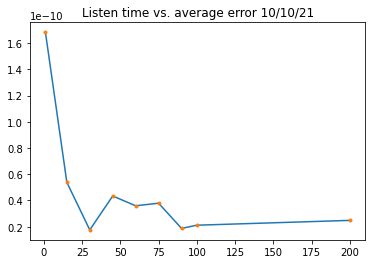

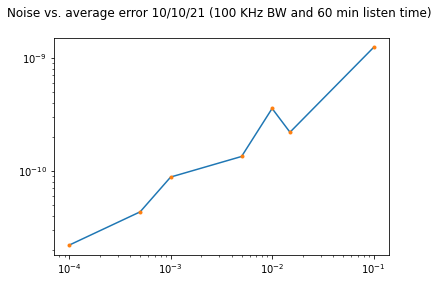

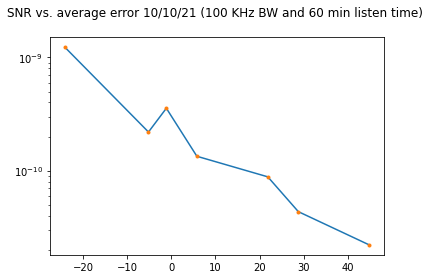

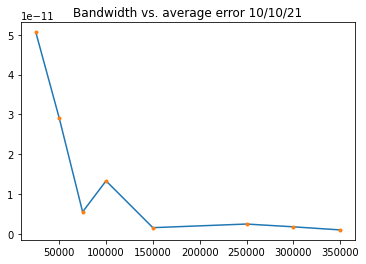

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
listen_res = [1.6826706714761364e-10, 5.38360165964593e-11, 1.7517702518306825e-11, 4.339190678938595e-11, 3.592365554022931e-11, 3.7891190841447016e-11, 1.8684267235661357e-11, 2.1110173855620502e-11, 2.478430645734449e-11]
listen_its = [1, 15, 30, 45, 60, 75, 90, 100, 200] #listen time in minutes
noise_res = [2.211357211802176e-11, 4.348440650979475e-11, 8.822919541407839e-11, 1.3403112398180038e-10, 3.5564866222977844e-10, 2.1946352947549105e-10, 1.2293091820012634e-09] #listen time is 60 min
noise_its = np.array([0.1e-3, 0.5e-3, 1e-3, 5e-3, 10e-3, 15e-3, 100e-3])
dB_FSPL = 61
snr_lin_its = (10*pow(10, -dB_FSPL/20))/noise_its
snr_its = 10*np.log(snr_lin_its)
bw_its = np.array([50e+3, 100e+3, 150e+3,  200e+3,300e+3,500e+3, 600e+3, 700e+3])/2
bw_res = [5.0634371318713065e-11, 2.9096624701711632e-11, 5.485472742949556e-12, 1.3291114023936595e-11, 1.5289680096180092e-12, 2.441947535096671e-12,  1.7435174177749804e-12, 9.661486564452666e-13]


plt.figure()
plt.plot(listen_its, listen_res)
plt.plot(listen_its, listen_res, ".")
plt.title("Listen time vs. average error 10/10/21")

plt.figure()
plt.plot(noise_its, noise_res)
plt.plot(noise_its, noise_res, ".")
plt.xscale("log")
plt.yscale("log")
plt.title("Noise vs. average error 10/10/21 (100 KHz BW and 60 min listen time) \n")

plt.figure()
plt.plot(snr_its, noise_res)
plt.plot(snr_its, noise_res, ".")
plt.yscale("log")
plt.title("SNR vs. average error 10/10/21 (100 KHz BW and 60 min listen time) \n")

plt.figure()
plt.plot(bw_its, bw_res)
plt.plot(bw_its, bw_res, ".")
plt.title("Bandwidth vs. average error 10/10/21")

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

#tx signal
f0 = 1e+3
Fs_tx = int(200e+3)
Tx_dt = 40.96e-3 #Tx random num sequence duration in seconds, nSymbols needs to be below 16777215
sps = 100
n_TxSymbol = int((Fs_tx*Tx_dt)/sps)
num_samples = n_TxSymbol*sps
"""
tx_signal_rand = sig.max_len_seq(24, state=[0,1,1,1,0,0,0,1,1,0,1,0,1,1,1,0,0,0,1,1,0,1,1,0], length=n_TxSymbol)[0]#generate PN code  is this the best way to do it

#do BPSK
t_index = np.linspace(0, Tx_dt, num_samples)
tx_sig_rad = tx_signal_rand*np.pi + np.pi/2
tx_sig_raw2 = np.array([])

for bit in tqdm(tx_sig_rad):
  pulse = np.zeros([sps])
  pulse.fill(bit)
  tx_sig_raw2 = np.concatenate((tx_sig_raw2, pulse))
tx_sig_raw = np.zeros(len(t_index))

for i in range(len(t_index)-1):
  tx_sig_raw[i] = np.cos(2*np.pi*f0*t_index[i]+tx_sig_raw2[i])

"""
#create wave object
tx_sig_raw = np.random.normal(loc=0, scale=np.sqrt(10), size=num_samples)

"""
#LPF with cutoff at 100 khz
fH = 0.75  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
N = int(np.ceil((4 / b)))
if not N % 2: N += 1  # Make sure that N is odd.
n = np.arange(N)
 
# Compute a low-pass filter with cutoff frequency fH.
hlpf = np.sinc(2 * fH * (n - (N - 1) / 2))
hlpf *= np.blackman(N)
hlpf = hlpf / np.sum(hlpf)

tx_sig_raw = sig.convolve(tx_sig_raw, hlpf)
"""

tx_sig = Wave(tx_sig_raw, Fs_tx)
tx_sig_raw = None
tx_sig_rad = None
tx_signal_rand = None
tx_sig_raw2 = None


#tag signal
Fs_tag = int(200e+3)
tag_dur = 1.28e-3
#tag_dur = Tx_dt/32
print(f"The tag signal is {tag_dur} sec long")
tindex_tag = np.linspace(0, tag_dur, int(tag_dur*Fs_tag))
tag_sig_raw = sig.square(tindex_tag*2*np.pi*10)

num_samples = Fs_tag*tag_dur
n =32
bits = (scipy.linalg.hadamard(n)+1)/2
sps = int(np.floor(num_samples/n))
print(f"The tag signal has {sps} samples per bit")
pulse_train = np.array([])
for bit in tqdm(bits[0]):
    pulse = np.zeros(sps)
    pulse.fill(bit)
    pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal

tag_sig = Wave(pulse_train, Fs_tag)
pulse_train = None
tag_sig_raw = None
tindex_tag = None

pulse_train = np.array([])
for bit in tqdm(bits[1]):
    pulse = np.zeros(sps)
    pulse.fill(bit)
    pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal
tag_sig2 = Wave(pulse_train, Fs_tag)
pulse_train = None
tag_sig_raw = None
tindex_tag = None

pulse_train = np.array([])
for bit in tqdm(bits[2]):
    pulse = np.zeros(sps)
    pulse.fill(bit)
    pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal

tag_sig3 = Wave(pulse_train, Fs_tag)
pulse_train = None
tag_sig_raw = None
tindex_tag = None

#reps_t = 10*60*60 #reps in time (sec)
reps_t = 60*60 #reps in time (sec)
reps = reps_t/Tx_dt
print(f"there are {reps} reps")

#simulation parameters
tof = 1.23456e-6
true_tag_delay = 0.5e-3
fs_rx = 200e+3
rx_sig= combineTagnTxFFT(tag_sig, tx_sig, fs_rx, tof, true_tag_delay)
rx_sig.samples *= 10
mean_sig_pow = np.average(rx_sig.samples)
#rx_sig.samples =np.real(rx_sig.samples)
rx_sig.samples += combineTagnTxFFT(tag_sig2, tx_sig, fs_rx, tof, true_tag_delay).samples*3
rx_sig.samples += combineTagnTxFFT(tag_sig3, tx_sig, fs_rx, tof, true_tag_delay).samples*5

dB_FSPL = 61 #Free space path loss
rx_sig.samples *= pow(10, -dB_FSPL/20) #converting FSPL in dB to lin
mean_sig_pow *= pow(10, -dB_FSPL/20)
#rx_sig.samples *= 0.00001

rx_sig.samples *= reps #repetitions in reciever
mean_sig_pow_listen = np.average(rx_sig.samples)

rx_sig.samples += np.random.normal(loc=0, scale=np.sqrt(reps)*np.sqrt(0.1e-3), size=len(rx_sig.samples)) #adding noise
mean_noise_pow = 0.1e-3
mean_noise_pow_listen = np.average(rx_sig.samples)-mean_sig_pow_listen

print(f"The SNR of the just the signal (no listen) is {np.abs(mean_sig_pow/mean_noise_pow)}, the SNR of the signal after listening {reps} times is {np.abs(mean_sig_pow_listen/mean_noise_pow_listen)}")

def findDelay2(rx_sig, tx_sig, tag_sig, pos_tof=0, pos_tag=0):
  ideal_rx = combineTagnTxFFT(tag_sig, tx_sig, rx_sig.fs, pos_tof, pos_tag)
  cor = sig.correlate(rx_sig.samples, ideal_rx.samples, mode="same")
  cor_t = np.linspace(-(len(rx_sig.samples)/2)/rx_sig.fs, (len(rx_sig.samples)/2)/rx_sig.fs, len(rx_sig.samples))
  return np.abs(cor_t[np.argmax(cor)]/2)

start = time.time()

#starting finding tof
rx_sig_copy = rx_sig.samples
rx_sig_copy2 = rx_sig.samples

#start round one
result = findDelay3(rx_sig, tx_sig, tag_sig, 0, 4e-6, 0, 1.28e-3, 0, 9)
rx_sig.samples -= combineTagnTxFFT(tag_sig, tx_sig, fs_rx, (result[0][0]+result[0][1])/2, (result[1][0]+result[1][1])/2).samples

result2 = findDelay3(rx_sig, tx_sig, tag_sig2, 0, 4e-6, 0, 1.28e-3, 0, 9)
rx_sig.samples -= combineTagnTxFFT(tag_sig2, tx_sig, fs_rx, (result2[0][0]+result2[0][1])/2, (result2[1][0]+result2[1][1])/2).samples

result3 = findDelay3(rx_sig, tx_sig, tag_sig3, 0, 4e-6, 0, 1.28e-3, 0, 9)
"""
#start round two
rx_sig.samples = rx_sig_copy2

rx_sig.samples -= combineTagnTxFFT(tag_sig3, tx_sig, fs_rx, (result3[0][0]+result3[0][1])/2, (result3[1][0]+result3[1][1])/2).samples

result = findDelay3(rx_sig, tx_sig, tag_sig, 0, 4e-6, 0, 1.28e-3, 0, 9)
rx_sig.samples -= combineTagnTxFFT(tag_sig, tx_sig, fs_rx, (result[0][0]+result[0][1])/2, (result[1][0]+result[1][1])/2).samples

result2 = findDelay3(rx_sig, tx_sig, tag_sig2, 0, 4e-6, 0, 1.28e-3, 0, 9)
"""
#round three
rx_sig_copy -= combineTagnTxFFT(tag_sig2, tx_sig, fs_rx, (result2[0][0]+result2[0][1])/2, (result2[1][0]+result2[1][1])/2).samples

rx_sig.samples = rx_sig_copy
result3 = findDelay3(rx_sig, tx_sig, tag_sig3, 0, 4e-6, 0, 1.28e-3, 0, 9)
rx_sig_copy -= combineTagnTxFFT(tag_sig3, tx_sig, fs_rx, (result3[0][0]+result3[0][1])/2, (result3[1][0]+result3[1][1])/2).samples

rx_sig.samples = rx_sig_copy

result = findDelay3(rx_sig, tx_sig, tag_sig, 0, 4e-6, 0, 1.28e-3, 0, 9)
#done
end = time.time()

print("")

print(result)
print(result3)
print("")
print(f"Elapsed time to find delay: {np.floor((end-start)/60)} min and {(end-start)%60} sec")


The tag signal is 0.00128 sec long
The tag signal has 8 samples per bit


100%|██████████| 32/32 [00:00<00:00, 24713.26it/s]

there are 87890.625 reps
The SNR of the just the signal (no listen) is 1.9047394430304299, the SNR of the signal after listening 87890.625 times is 1492.943054024622



[(1.2344076121469285e-06, 1.234407618806076e-06), (0.0, 8.067155984355737e-16)]
[(1.2334246148070926e-06, 1.2334246214662402e-06), (0.00017986729065361696, 0.00017986729065442368)]

Elapsed time to find delay: 33.0 min and 41.02202534675598 sec


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

#tx signal
f0 = 1e+3
Fs_tx = int(200e+3)
Tx_dt = 40.96e-3 #Tx random num sequence duration in seconds, nSymbols needs to be below 16777215
sps = 100
n_TxSymbol = int((Fs_tx*Tx_dt)/sps)
num_samples = n_TxSymbol*sps
"""
tx_signal_rand = sig.max_len_seq(24, state=[0,1,1,1,0,0,0,1,1,0,1,0,1,1,1,0,0,0,1,1,0,1,1,0], length=n_TxSymbol)[0]#generate PN code  is this the best way to do it

#do BPSK
t_index = np.linspace(0, Tx_dt, num_samples)
tx_sig_rad = tx_signal_rand*np.pi + np.pi/2
tx_sig_raw2 = np.array([])

for bit in tqdm(tx_sig_rad):
  pulse = np.zeros([sps])
  pulse.fill(bit)
  tx_sig_raw2 = np.concatenate((tx_sig_raw2, pulse))
tx_sig_raw = np.zeros(len(t_index))

for i in range(len(t_index)-1):
  tx_sig_raw[i] = np.cos(2*np.pi*f0*t_index[i]+tx_sig_raw2[i])

"""
#create wave object
tx_sig_raw = np.random.normal(loc=0, scale=np.sqrt(10), size=num_samples)

"""
#LPF with cutoff at 100 khz
fH = 0.75  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
N = int(np.ceil((4 / b)))
if not N % 2: N += 1  # Make sure that N is odd.
n = np.arange(N)
 
# Compute a low-pass filter with cutoff frequency fH.
hlpf = np.sinc(2 * fH * (n - (N - 1) / 2))
hlpf *= np.blackman(N)
hlpf = hlpf / np.sum(hlpf)

tx_sig_raw = sig.convolve(tx_sig_raw, hlpf)
"""

tx_sig = Wave(tx_sig_raw, Fs_tx)
tx_sig_raw = None
tx_sig_rad = None
tx_signal_rand = None
tx_sig_raw2 = None


#tag signal
Fs_tag = int(200e+3)
tag_dur = 1.28e-3
#tag_dur = Tx_dt/32
print(f"The tag signal is {tag_dur} sec long")
tindex_tag = np.linspace(0, tag_dur, int(tag_dur*Fs_tag))
tag_sig_raw = sig.square(tindex_tag*2*np.pi*10)

num_samples = Fs_tag*tag_dur
n =32
bits = (scipy.linalg.hadamard(n)+1)/2
sps = int(np.floor(num_samples/n))
print(f"The tag signal has {sps} samples per bit")
pulse_train = np.array([])
for bit in tqdm(bits[0]):
    pulse = np.zeros(sps)
    pulse.fill(bit)
    pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal

tag_sig = Wave(pulse_train, Fs_tag)
pulse_train = None
tag_sig_raw = None
tindex_tag = None

pulse_train = np.array([])
for bit in tqdm(bits[1]):
    pulse = np.zeros(sps)
    pulse.fill(bit)
    pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal
tag_sig2 = Wave(pulse_train, Fs_tag)
pulse_train = None
tag_sig_raw = None
tindex_tag = None

pulse_train = np.array([])
for bit in tqdm(bits[2]):
    pulse = np.zeros(sps)
    pulse.fill(bit)
    pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal

tag_sig3 = Wave(pulse_train, Fs_tag)
pulse_train = None
tag_sig_raw = None
tindex_tag = None

#reps_t = 10*60*60 #reps in time (sec)
reps_t = 1*60*60 #reps in time (sec)
reps = int(reps_t/Tx_dt)
print(f"there are {reps} reps")

#simulation parameters
tof = 1.23456e-6
true_tag_delay = 0.5e-3
fs_rx = 200e+3
mean_noise_pow = 0.1e-3
dB_FSPL = 61 #Free space path loss
jitter_mag = 1e-6

#simulating signal
rx_sig = combineTagnTxFFT(tag_sig, tx_sig, fs_rx, tof, true_tag_delay)
rx_sig.samples *= 10
mean_sig_pow = np.average(rx_sig.samples)
"""
#rx_sig.samples =np.real(rx_sig.samples)
rx_sig.samples += combineTagnTxFFT(tag_sig2, tx_sig, fs_rx, tof, true_tag_delay).samples*3
rx_sig.samples += combineTagnTxFFT(tag_sig3, tx_sig, fs_rx, tof, true_tag_delay).samples*5
"""

rx_sig.samples *= pow(10, -dB_FSPL/20) #converting FSPL in dB to lin
mean_sig_pow *= pow(10, -dB_FSPL/20)
#rx_sig.samples *= 0.00001

#modeling jitter
jitter = lambda x: jitter_mag*np.sin(2*np.pi*x/reps)
samps = np.zeros(len(rx_sig.samples), dtype="complex128")
for i in range(reps+1):
  samps += fracDelayfft(jitter(i), rx_sig) #rx sig with jitter

rx_sig.samples = samps
mean_sig_pow_listen = np.average(rx_sig.samples)

for i in range(reps+1):
  rx_sig.samples += np.random.normal(loc=0, scale=np.sqrt(mean_noise_pow), size=len(rx_sig.samples)) #adding noise

mean_noise_pow_listen = np.average(rx_sig.samples)-mean_sig_pow_listen

print(f"The SNR of the just the signal (no listen) is {np.abs(mean_sig_pow/mean_noise_pow)}, the SNR of the signal after listening {reps} times is {np.abs(mean_sig_pow_listen/mean_noise_pow_listen)}")


start = time.time()

#starting finding tof
"""
rx_sig_copy = rx_sig.samples
rx_sig_copy2 = rx_sig.samples

#start round one
result = findDelay3(rx_sig, tx_sig, tag_sig, 0, 4e-6, 0, 1.28e-3, 0, 9)

rx_sig.samples -= combineTagnTxFFT(tag_sig, tx_sig, fs_rx, (result[0][0]+result[0][1])/2, (result[1][0]+result[1][1])/2).samples

result2 = findDelay3(rx_sig, tx_sig, tag_sig2, 0, 4e-6, 0, 1.28e-3, 0, 9)
rx_sig.samples -= combineTagnTxFFT(tag_sig2, tx_sig, fs_rx, (result2[0][0]+result2[0][1])/2, (result2[1][0]+result2[1][1])/2).samples

result3 = findDelay3(rx_sig, tx_sig, tag_sig3, 0, 4e-6, 0, 1.28e-3, 0, 9)

#start round two
rx_sig.samples = rx_sig_copy2

rx_sig.samples -= combineTagnTxFFT(tag_sig3, tx_sig, fs_rx, (result3[0][0]+result3[0][1])/2, (result3[1][0]+result3[1][1])/2).samples

result = findDelay3(rx_sig, tx_sig, tag_sig, 0, 4e-6, 0, 1.28e-3, 0, 9)
rx_sig.samples -= combineTagnTxFFT(tag_sig, tx_sig, fs_rx, (result[0][0]+result[0][1])/2, (result[1][0]+result[1][1])/2).samples

result2 = findDelay3(rx_sig, tx_sig, tag_sig2, 0, 4e-6, 0, 1.28e-3, 0, 9)

#round three
rx_sig_copy -= combineTagnTxFFT(tag_sig2, tx_sig, fs_rx, (result2[0][0]+result2[0][1])/2, (result2[1][0]+result2[1][1])/2).samples

rx_sig.samples = rx_sig_copy
result3 = findDelay3(rx_sig, tx_sig, tag_sig3, 0, 4e-6, 0, 1.28e-3, 0, 9)
rx_sig_copy -= combineTagnTxFFT(tag_sig3, tx_sig, fs_rx, (result3[0][0]+result3[0][1])/2, (result3[1][0]+result3[1][1])/2).samples

rx_sig.samples = rx_sig_copy
"""
result = findDelay3(rx_sig, tx_sig, tag_sig, 0, 4e-6, 0, 1.28e-3, 0, 9)
#done
end = time.time()

print("")

print(result)

print("")
print(f"Elapsed time to find delay: {np.floor((end-start)/60)} min and {(end-start)%60} sec")


The tag signal is 0.00128 sec long
The tag signal has 8 samples per bit


100%|██████████| 32/32 [00:00<00:00, 16983.14it/s]

there are 87890 reps


The SNR of the just the signal (no listen) is 5.32803803142, the SNR of the signal after listening 87890 times is 1142.1976096013577

[(1.2345485188753747e-06, 1.2345485255345222e-06), (0.0, 8.067155984355737e-16)]


NameError: ignored

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import time




def eval(noise_pow=0.1e-3, listen_time=10*60*60, dB_FSPL=61, Fs_tx=200e+3, tag_switch_width=1e-4):
  error_sum = 0
  error_res = []
  pre_snr = []
  post_snr = []
  #tx signal
  f0 = 1e+3
  Tx_dt = 40.96e-3 #Tx random num sequence duration in seconds, nSymbols needs to be below 16777215
  sps = 100
  for k in range(4):
    n_TxSymbol = int((Fs_tx*Tx_dt)/sps)
    num_samples = n_TxSymbol*sps
    #create wave object
    tx_sig_raw = np.random.normal(loc=0, scale=np.sqrt(10), size=num_samples)

    """
    #LPF with cutoff at 100 khz
    fH = 0.75  # Cutoff frequency as a fraction of the sampling rate (in (0, 0.5)).
    b = 0.08  # Transition band, as a fraction of the sampling rate (in (0, 0.5)).
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1  # Make sure that N is odd.
    n = np.arange(N)
    
    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (n - (N - 1) / 2))
    hlpf *= np.blackman(N)
    hlpf = hlpf / np.sum(hlpf)

    tx_sig_raw = sig.convolve(tx_sig_raw, hlpf)
    """

    tx_sig = Wave(tx_sig_raw, Fs_tx)
    tx_sig_raw = None
    tx_sig_rad = None
    tx_signal_rand = None
    tx_sig_raw2 = None


    #tag signal
    #tag signal
    Fs_tag = int(200e+3)
    tag_dur = 1.28e-3
    #tag_dur = Tx_dt/32
    print(f"The tag signal is {tag_dur} sec long")
    tindex_tag = np.linspace(0, tag_dur, int(tag_dur*Fs_tag))
    tag_sig_raw = sig.square(tindex_tag*2*np.pi*10)

    num_samples = Fs_tag*tag_dur
    n =32
    bits = (scipy.linalg.hadamard(n)+1)/2
    sps = int(np.floor(num_samples/n))
    print(f"The tag signal has {sps} samples per bit")
    pulse_train = np.array([])
    for bit in tqdm(bits[0]):
        pulse = np.zeros(sps)
        pulse.fill(bit)
        pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal

    tag_sig = Wave(pulse_train, Fs_tag)
    pulse_train = None
    tag_sig_raw = None
    tindex_tag = None
    pulse_train = np.array([])
    for bit in tqdm(bits[1]):
        pulse = np.zeros(sps)
        pulse.fill(bit)
        pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal
    tag_sig2 = Wave(pulse_train, Fs_tag)
    pulse_train = None
    tag_sig_raw = None
    tindex_tag = None

    pulse_train = np.array([])
    for bit in tqdm(bits[2]):
        pulse = np.zeros(sps)
        pulse.fill(bit)
        pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal

    tag_sig3 = Wave(pulse_train, Fs_tag)
    pulse_train = None
    tag_sig_raw = None
    tindex_tag = None
    reps_t = listen_time #reps in time (sec)
    reps = int(reps_t/Tx_dt)
    print(f"there are {reps} reps")
    fs_rx = Fs_tx
    tof = 1.23456789e-6
    true_tag_delay = 0.5e-3
    mean_noise_pow = noise_pow
    #simulating signal
    rx_sig = combineTagnTxFFT(tag_sig, tx_sig, fs_rx, tof, true_tag_delay)
    rx_sig.samples *= 10
    mean_sig_pow = np.average(rx_sig.samples)
    jitter_mag = 10e-9
    """
    #rx_sig.samples =np.real(rx_sig.samples)
    rx_sig.samples += combineTagnTxFFT(tag_sig2, tx_sig, fs_rx, tof, true_tag_delay).samples*3
    rx_sig.samples += combineTagnTxFFT(tag_sig3, tx_sig, fs_rx, tof, true_tag_delay).samples*5
    """

    rx_sig.samples *= pow(10, -dB_FSPL/20) #converting FSPL in dB to lin
    mean_sig_pow *= pow(10, -dB_FSPL/20)
    #rx_sig.samples *= 0.00001

    #modeling jitter
    jitter = lambda x: jitter_mag*np.sin(2*np.pi*x/reps)
    samps = np.zeros(len(rx_sig.samples), dtype="complex128")
    for i in range(reps+1):
      samps += fracDelayfft(jitter(i), rx_sig) #rx sig with jitter

    rx_sig.samples = samps
    mean_sig_pow_listen = np.average(rx_sig.samples)

    for i in range(reps+1):
      rx_sig.samples += np.random.normal(loc=0, scale=np.sqrt(mean_noise_pow), size=len(rx_sig.samples)) #adding noise

    mean_noise_pow_listen = np.average(rx_sig.samples)-mean_sig_pow_listen
    print(f"The SNR of the just the signal (no listen) is {np.abs(mean_sig_pow/mean_noise_pow)}, the SNR of the signal after listening {reps} times is {np.abs(mean_sig_pow_listen/mean_noise_pow_listen)}")

    pre_snr.append(np.abs(mean_sig_pow/mean_noise_pow))
    post_snr.append(np.abs(mean_sig_pow_listen/mean_noise_pow_listen))

    #starting finding tof
    result = findDelay3(rx_sig, tx_sig, tag_sig, 0, 4e-6, 0, 1.28e-3, 0, 9)
    error_sum += np.abs(1.23456789e-6 - (result[0][0]+result[0][1])/2)
    error_res.append((result[0][0]+result[0][1])/2)
    print(f"The error was {(result[0][0]+result[0][1])/2} sec")
  print(f"The average error is {error_sum/3} sec")
  return error_sum/10, error_res, pre_snr, post_snr
 
its = [1]
res = []
for it in its:
  e, r, pre, post = eval()
  print(r)
  print(pre)
  print(post)
  res.append(e) 

listen_res = [1.6826706714761364e-10, 5.38360165964593e-11, 1.7517702518306825e-11, 4.339190678938595e-11, 3.592365554022931e-11, 3.7891190841447016e-11, 1.8684267235661357e-11, 2.1110173855620502e-11, 2.478430645734449e-11]
listen_its = [1, 15, 30, 45, 60, 75, 90, 100, 200] #listen time in minutes
noise_res = [2.211357211802176e-11, 8.822919541407839e-11, 3.5564866222977844e-10, 4.348440650979475e-11, 1.3403112398180038e-10, 2.1946352947549105e-10, 1.2293091820012634e-09] #listen time is 60 min
noise_its = [0.1e-3,1e-3,10e-3, 0.5e-3, 5e-3, 15e-3, 100e-3]
bw_its = np.array([100e+3,200e+3,300e+3,500e+3, 150e+3, 50e+3, 600e+3, 700e+3])/2
bw_res = [2.9096624701711632e-11, 2.3291114023936595e-11, 1.5289680096180092e-12, 2.441947535096671e-12, 5.485472742949556e-12, 5.0634371318713065e-11, 1.7435174177749804e-12, 9.661486564452666e-13]

tag_switch_width_its = [1e-4, 1e-5, 6e-6]
tag_switch_width_res = [9.503661298376797e-12, 2.0083954139881335e-11, 2.024547314935117e-11]

The tag signal is 0.00128 sec long
The tag signal has 8 samples per bit


100%|██████████| 32/32 [00:00<00:00, 22853.35it/s]

there are 878906 reps


The SNR of the just the signal (no listen) is 3.3775109175972964, the SNR of the signal after listening 878906 times is 1961.937980412552
The error was 1.2345720668694811e-06 sec
The tag signal is 0.00128 sec long
The tag signal has 8 samples per bit


100%|██████████| 32/32 [00:00<00:00, 56417.71it/s]

there are 878906 reps


The SNR of the just the signal (no listen) is 1.2703155943103226, the SNR of the signal after listening 878906 times is 1351.2008328740183
The error was 1.2345725854505919e-06 sec
The tag signal is 0.00128 sec long
The tag signal has 8 samples per bit


100%|██████████| 32/32 [00:00<00:00, 22075.28it/s]

there are 878906 reps


The SNR of the just the signal (no listen) is 8.270383430926062, the SNR of the signal after listening 878906 times is 10990.66885260677
The error was 1.2345619697290044e-06 sec
The tag signal is 0.00128 sec long
The tag signal has 8 samples per bit


100%|██████████| 32/32 [00:00<00:00, 57802.64it/s]

there are 878906 reps


The SNR of the just the signal (no listen) is 0.5032092985003589, the SNR of the signal after listening 878906 times is 1311.4271663443
The error was 1.2345559883578723e-06 sec
The average error is 8.898077732091998e-12 sec
[1.2345720668694811e-06, 1.2345725854505919e-06, 1.2345619697290044e-06, 1.2345559883578723e-06]
[3.3775109175972964, 1.2703155943103226, 8.270383430926062, 0.5032092985003589]
[1961.937980412552, 1351.2008328740183, 10990.66885260677, 1311.4271663443]


# OLD

In [ ]:
##DEPRECEATED stuff

#I'm working on doing a memory usage comparison between this method and sig.resample 
#this can be done a lot faster using workers/vectorizing it
def sincInterp(signal, fs_old, fs_new): #based on https://gist.github.com/dangom/036fd43059801f4da035a75d071287ba
  dt = 1/fs_new - 1/fs_old
  n_samps = int(fs_new*(len(signal)/fs_old))
  resampled_sig = np.zeros((n_samps)) #generate zero filled array to store new resampled data
  for i in range(n_samps):
    filter = np.sinc(dt) #build sinc filter to interpolate data
    resampled_sig[i] = np.sum(filter*signal) #resample the signal, np.sum reduces memory usage
  return resampled_sig

#same as above but with scipy pearsonr lib
def findCorScipy(rx_sig, tx_sig, tag_sig, tof, tag_delay):
  ideal_rx = combineTagnTxFFT(tag_sig, tx_sig, rx_sig.fs, tof, tag_delay)
  #cor = sig.correlate(rx_sig.samples, ideal_rx.samples, mode="same")
  #return cor[np.argmax(cor)]
  cor, p_val = scipy.stats.pearsonr(rx_sig.samples, ideal_rx.samples)
  return cor

def fracDelay(delay, wave):
  samp_delay = delay*wave.fs
  #N = int(samp_delay)*2 + 1 #filter should have delay of (n-1)/2 so the inverse would be n = 2*delay + 1
  N = 21
  tau = samp_delay-int(samp_delay)
  if tau > 0.5:
    tau -= 1
  if tau < -0.5:
    tau += 1
  # Create and apply fractional delay filter
  delay = tau # fractional delay, in samples
  N = 21 # number of taps
  n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
  h = np.sinc(n - delay) # calc filter taps
  h *= np.hamming(N) # window the filter to make sure it decays to 0 on both sides
  h /= np.sum(h) # normalize to get unity gain, we don't want to change the amplitude/power
  #partially_shifted = np.concatenate((wave.samples[int(samp_delay):], wave.samples[:int(samp_delay)]))
  #partially_shifted = np.concatenate((wave.samples[(len(wave.samples)-int(samp_delay)):], wave.samples[:(len(wave.samples)-int(samp_delay))]))
  #partially_shifted = np.concatenate((np.zeros((int(samp_delay))), wave.samples[:(len(wave.samples)-int(samp_delay))]))
  #wave.samples = sig.convolve(h, partially_shifted)
  wave.samples = np.concatenate((wave.samples[(len(wave.samples)-int(samp_delay)):], wave.samples[:(len(wave.samples)-int(samp_delay))]))
  wave.samples = sig.convolve(wave.samples, h, "same")
  return wave.samples[:]

def combineTagnTxNoise(tag_sig_, tx_sig_, Fs, tof, tag_offset, SNRdB): #assumes tof equal in both directions and that tx sig is longer than tag sig, also assumes delays are small relative to the length of the signal

  Fs_tx = tx_sig_.fs
  Fs_tag = tag_sig_.fs
  tx_sig = tx_sig_.samples
  tag_sig = tag_sig_.samples
  #to apply the delays a fractional delay filter might be more efficient but this method allows for a more arbitrary delay
  #a TODO is to implement a fractional delay filter with also a finite sample delay to get the same arbitrary delay but hopefully keep code cleaner and increase delay precision 
  #resample signals
  if not Fs == Fs_tx:
    #tx_sig = sincInterp(tx_sig, Fs_tx, Fs)
    tx_sig = sig.resample(tx_sig, int(Fs*tx_sig_.dur))
  #resample signals
  if not Fs == Fs_tag:
    #tag_sig = sincInterp(tag_sig, Fs_tag, Fs)
    tag_sig = sig.resample(tag_sig, int(Fs*tag_sig_.dur))
  #figure out delay due to tof approaching the tag
  delayed_samps_tof = int(np.floor(tof*Fs))
  delayed_samps_tag = int(np.floor(tag_offset*Fs))

  #apply delays and figure out the emitted tag signal)
  tx_sig_delayed = np.concatenate((tx_sig[delayed_samps_tof:], tx_sig[:delayed_samps_tof]))
  tag_sig = np.concatenate((tag_sig[delayed_samps_tag:], tag_sig[:delayed_samps_tag]))
  tiled_tag_sig = np.tile(tag_sig, int(np.floor(tx_sig_.dur/tag_sig_.dur)))
  tag_sig_full = np.concatenate((tiled_tag_sig, tag_sig[:(len(tx_sig)-len(tiled_tag_sig))]))
  #returning_sig = sig.convolve(tx_sig_delayed, tag_sig_full)#automatically switches between fft and td based on which will run faster, ~2x faster than np.convolve
  returning_sig_mult = (tx_sig_delayed)*tag_sig_full #element wise multiplication is the best approximation
  incident_tag_sig = Wave(returning_sig_mult, Fs)
  #adding noise with given SNR
  SNRlin = 10**(SNRdB/10)
  N = len(incident_tag_sig.samples)
  noise_rand = np.random.randn(N)
  noise_psd = incident_tag_sig.psd/SNRlin
  noise = np.sqrt(noise_psd/2)*noise_rand 
  #apply returning tof
  incident_tag_sig.samples = incident_tag_sig.samples+noise
  returning_sig_delayed_ =  np.concatenate((incident_tag_sig.samples[delayed_samps_tof:], incident_tag_sig.samples[:delayed_samps_tof]))

  #return both emitted tag signal and incident signal to the receiver
  returning_sig_delayed = Wave(returning_sig_delayed_, Fs)
  #adding noise with given SNR
  SNRlin = 10**(SNRdB/10)
  N = len(returning_sig_delayed.samples)
  noise_rand = np.random.randn(N)
  noise_psd = returning_sig_delayed.psd/SNRlin
  noise = np.sqrt(noise_psd/2)*noise_rand 
  returning_sig_delayed.samples = returning_sig_delayed.samples+noise
  return returning_sig_delayed



def findDelay2(rx_sig, tx_sig, tag_sig):
  ideal_rx = combineTagnTx(tag_sig, tx_sig, rx_sig.fs, 0, 0)
  cor = sig.correlate(rx_sig.samples, ideal_rx.samples, mode="same")
  cor_t = np.linspace(-(len(rx_sig.samples)/2)/rx_sig.fs, (len(rx_sig.samples)/2)/rx_sig.fs, len(rx_sig.samples))
  return np.abs(cor_t[np.argmax(cor)]/2)

def findDelay2Noise(rx_sig, tx_sig, tag_sig, SNRdB):
  ideal_rx = combineTagnTx(tag_sig, tx_sig, rx_sig.fs, 0, 0)
  cor = sig.correlate(rx_sig.samples, ideal_rx.samples, mode="same", method="direct")
  cor_t = np.linspace(-(len(rx_sig.samples)/2)/rx_sig.fs, (len(rx_sig.samples)/2)/rx_sig.fs, len(rx_sig.samples))
  return np.abs(cor_t[np.argmax(cor)]/2)

#fairly naive method to do this
def findDelay(rx_sig, tx_sig, tag_sig, max_runs, max_tof, max_tag):
  tof_guess_d = max_tof/max_runs
  tof_guess = 0
  tag_guess_d = max_tag/max_runs
  tag_guess = 0
  max_cor = 0
  for i in tqdm(range(max_runs)):
    rx_test = combineTagnTx(tag_sig, tx_sig, rx_sig.fs, tof_guess, 0) #look only at tof
    corelation = sig.correlate(rx_sig.samples, rx_test.samples)
    if np.max(corelation) > max_cor and not tof_guess == 0:
      tof_best = tof_guess
      print("tof", tof_best)
      max_cor = np.max(corelation)
    tof_guess += tof_guess_d
  max_cor = 0
  for i in tqdm(range(max_runs)):
    rx_test = combineTagnTx(tag_sig, tx_sig, rx_sig.fs, 0, tag_guess) #look only at tag offsets
    corelation = sig.correlate(rx_sig.samples, rx_test.samples)
    if np.max(corelation) > max_cor and not tag_guess == 0:
      tag_best = tag_guess
      print("tag", tag_best)
      max_cor = np.max(corelation)
    tag_guess += tag_guess_d
  return tof_best, tag_best


  def fracDelayOLD(delay, wave):
  samp_delay = delay*wave.fs
  N = int(samp_delay)*2 + 1 #filter should have delay of (n-1)/2 so the inverse would be n = 2*delay + 1
  tau = samp_delay-int(samp_delay)
  if tau > 0.5:
    N += 1
    tau -= 1
  if tau < -0.5:
    N -= 1
    tau += 1
  tau = 0.3  # Fractional delay [samples].
  N = 21     # Filter length.
  n = np.arange(N)
  
  # Compute sinc filter.
  h = np.sinc(n - (N - 1) / 2 - tau)
  
  # Multiply sinc filter by window
  h *= np.blackman(N)
  
  # Normalize to get unity gain.
  h /= np.sum(h)
  #partially_shifted = np.concatenate((wave.samples[int(samp_delay):], wave.samples[:int(samp_delay)]))
  partially_shifted = np.concatenate((wave.samples[int(samp_delay):], np.zeros((int(samp_delay)))))
  wave.samples = sig.convolve(h, partially_shifted)
  #wave.samples = sig.convolve(h, wave.samples)
  return wave.samples


100%|██████████| 13/13 [00:00<00:00, 38947.11it/s]



1.6666667785464329e-10


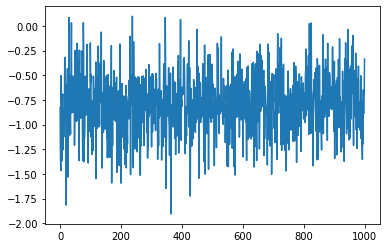

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

#tx signal
f0 = 1e+3
Fs_tx = int(200e+3)
Tx_dt = 81.92e-3 #Tx random num sequence duration in seconds, nSymbols needs to be below 16777215
sps = 2
n_TxSymbol = int((Fs_tx*Tx_dt)/sps)
num_samples = int(Fs_tx*Tx_dt)
tx_signal_rand = sig.max_len_seq(24, state=[0,1,1,1,0,0,0,1,1,0,1,0,1,1,1,0,0,0,1,1,0,1,1,0], length=n_TxSymbol)[0]#generate PN code  is this the best way to do it
"""
tx_sig_raw2 = np.array([])
for bit in tqdm(tx_signal_rand):
  pulse = np.zeros([sps])
  pulse.fill(bit)
  tx_sig_raw2 = np.concatenate((tx_sig_raw2, pulse))

tx_sig_rad = (tx_signal_rand*360/2)*np.pi/180 #set up BPSK
tx_sig_symbols = np.cos(tx_sig_rad)
tx_sig_raw = np.repeat(tx_sig_symbols, sps)
plt.figure()
plt.plot(tx_sig_raw[:100])
#now shape the pulse to reduce bandwidth, not used
n_taps = 101
beta= 0.35
T_samp = sps
t = np.arange(-51, 52) #array from -51 to +51
h = np.sinc(t/T_samp)*np.cos(np.pi*beta*t/T_samp) / (1-(2*beta*t/T_samp)**2) #simple raised cosine filter
shaped_tx = sig.convolve(tx_sig_raw2, h)
"""
#do BPSK
t_index = np.linspace(0, Tx_dt, num_samples)
tx_sig_rad = tx_signal_rand*np.pi + np.pi 
tx_sig_raw2 = np.array([])
for bit in tqdm(tx_sig_rad):
  pulse = np.zeros([sps])
  pulse.fill(bit)
  tx_sig_raw2 = np.concatenate((tx_sig_raw2, pulse))

tx_sig_raw = np.cos(2*np.pi*f0*(t_index+tx_sig_raw2))


#create wave object
tx_sig = Wave(tx_sig_raw.astype("float16"), Fs_tx)
tx_sig_raw = None
tx_sig_rad = None
tx_signal_rand = None
tx_sig_raw2 = None




#tag signal
Fs_tag = int(100e+3)
tag_dur = 2.56e-3
tindex_tag = np.linspace(0, tag_dur, int(tag_dur*Fs_tag))
tag_sig_raw = sig.square(tindex_tag*2*np.pi*10)

num_samples = Fs_tag*tag_dur
bits = [1,1,1,1,1,0,0,1,1,0,1,0,1] # 13 bit long barker code
sps = int(np.floor(num_samples/len(bits)))
pulse_train = np.array([])
for bit in tqdm(bits):
    pulse = np.zeros(sps)
    pulse.fill(bit)
    pulse_train = np.concatenate((pulse_train, pulse)) # add the 8 samples to the signal

tag_sig = Wave(pulse_train.astype("float16"), Fs_tag)
pulse_train = None
tag_sig_raw = None
tindex_tag = None


SNRdB = 6

rx_sig = combineTagnTxNoise(tag_sig, tx_sig, 1.5e+9, 3e-9, 0.001, SNRdB)

result = findDelay2(rx_sig, tx_sig, tag_sig)
#tof_pred, tag_pred = findDelay(rx_sig, tx_sig, tag_sig, 100, 1, 1)

#tof_pred, tag_pred = findDelay(rx_sig, tx_sig, tag_sig, 100, 1, 1)
plt.figure()
plt.plot(rx_sig.samples[:1000])




print("")
"""
print(tof_pred)
print(tag_pred)
"""
print(result)

100%|██████████| 13/13 [00:00<00:00, 35778.18it/s]


1.2500031250084476e-06


20it [00:02,  6.97it/s]

The maximum correlation is at a ToF of:  1.2e-06


'\n\ndef recur_search(rx_sig, tx_sig, tag_sig, max_cor, iter, max_iter, start_spacing=0.001):\n  if iter == 0:\n    granular_guess = findDelay2(rx_sig, tx_sig, tag_sig, pos_tof=max_cor[1], pos_tag=max_cor[2])\n  else:\n    granular_guess = max_cor[1]\n  print(granular_guess)\n  tof_pos_init = np.r_[granular_guess-start_spacing*10**(-iter+1):granular_guess+start_spacing*10**(-iter+1):start_spacing*10**(-iter)] #create a 1% window around the granular guess to search for the ideal coorelation \n  for i, tof_pos in tqdm(enumerate(tof_pos_init)):\n    tag_pos = 0\n    j = 0\n    cor = np.abs(findCor(rx_sig, tx_sig, tag_sig, tof_pos, tag_pos))\n    #print(" \n Testing")\n    #print("Tested tof:",tof_pos)\n    #print("Correlation", cor)\n    if max_cor[0] < cor and not tof_pos == 0:\n      print("Found possible match!")\n      max_cor = [cor, tof_pos, tag_pos]\n      if i > 0:\n        tof_pos_init_next = np.linspace(tof_pos_init[i-1], tof_pos_init[i+1], 16)\n      else:\n        tof_pos_init

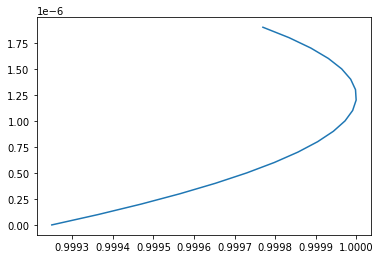

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

#tx signal
f0 = 1e+3
Fs_tx = int(200e+3)
Tx_dt = 2 #Tx random num sequence duration in seconds, nSymbols needs to be below 16777215
sps = 100
n_TxSymbol = int((Fs_tx*Tx_dt)/sps)
num_samples = int(Fs_tx*Tx_dt)
tx_signal_rand = sig.max_len_seq(24, state=[0,1,1,1,0,0,0,1,1,0,1,0,1,1,1,0,0,0,1,1,0,1,1,0], length=n_TxSymbol)[0]#generate PN code  is this the best way to do it

#do BPSK
t_index = np.linspace(0, Tx_dt, num_samples)
tx_sig_rad = tx_signal_rand*np.pi + np.pi/2
tx_sig_raw2 = np.array([])
for bit in tqdm(tx_sig_rad):
  pulse = np.zeros([sps])
  pulse.fill(bit)
  tx_sig_raw2 = np.concatenate((tx_sig_raw2, pulse))
tx_sig_raw = np.zeros(len(t_index))
for i in range(len(t_index)-1):
  tx_sig_raw[i] = np.cos(2*np.pi*f0*t_index[i]+tx_sig_raw2[i])


#create wave object
tx_sig = Wave(tx_sig_raw, Fs_tx)
tx_sig_raw = None
tx_sig_rad = None
tx_signal_rand = None
tx_sig_raw2 = None



#tag signal
Fs_tag = int(200e+3)
tag_dur = 2.56e-3
tindex_tag = np.linspace(0, tag_dur, int(tag_dur*Fs_tag))
tag_sig_raw = sig.square(tindex_tag*2*np.pi*10)

num_samples = Fs_tag*tag_dur
bits = [1,1,1,1,1,0,0,1,1,0,1,0,1] # 13 bit long barker code
sps = int(np.floor(num_samples/len(bits)))
pulse_train = np.array([])
for bit in tqdm(bits):
    pulse = np.zeros(sps)
    pulse.fill(bit)
    pulse_train = np.concatenate((pulse_train, pulse)) # add the 8 samples to the signal

tag_sig = Wave(pulse_train, Fs_tag)
pulse_train = None
tag_sig_raw = None
tindex_tag = None


SNRlin = 100

rx_sig = combineTagnTxFFT(tag_sig, tx_sig, 200e+3, 1.2345e-6, 0) #1.2324e-3
def findDelay2(rx_sig, tx_sig, tag_sig, pos_tof=0, pos_tag=0):
  ideal_rx = combineTagnTxFFT(tag_sig, tx_sig, rx_sig.fs, pos_tof, pos_tag)
  cor = sig.correlate(rx_sig.samples, ideal_rx.samples, mode="same")
  cor_t = np.linspace(-(len(rx_sig.samples)/2)/rx_sig.fs, (len(rx_sig.samples)/2)/rx_sig.fs, len(rx_sig.samples))
  return np.abs(cor_t[np.argmax(cor)]/2)
granular_guess = findDelay2(rx_sig, tx_sig, tag_sig)
print(granular_guess)

start_spacing = 1e-7
max_cor = [0, 100, 100]
tof_pos_init = np.r_[0:2000e-9:start_spacing] 
tag_delay_pos_init = np.linspace(0, 1, 16)
cor_for = []
for i, tof_pos in tqdm(enumerate(tof_pos_init)):
  cor = findCor(rx_sig, tx_sig, tag_sig, tof_pos, 0)
  cor_for.append(cor)

plt.figure()

plt.plot(cor_for, tof_pos_init)
print("The maximum correlation is at a ToF of: ", tof_pos_init[np.argmax(cor_for)])

"""

def recur_search(rx_sig, tx_sig, tag_sig, max_cor, iter, max_iter, start_spacing=0.001):
  if iter == 0:
    granular_guess = findDelay2(rx_sig, tx_sig, tag_sig, pos_tof=max_cor[1], pos_tag=max_cor[2])
  else:
    granular_guess = max_cor[1]
  print(granular_guess)
  tof_pos_init = np.r_[granular_guess-start_spacing*10**(-iter+1):granular_guess+start_spacing*10**(-iter+1):start_spacing*10**(-iter)] #create a 1% window around the granular guess to search for the ideal coorelation 
  for i, tof_pos in tqdm(enumerate(tof_pos_init)):
    tag_pos = 0
    j = 0
    cor = np.abs(findCor(rx_sig, tx_sig, tag_sig, tof_pos, tag_pos))
    #print(" \n Testing")
    #print("Tested tof:",tof_pos)
    #print("Correlation", cor)
    if max_cor[0] < cor and not tof_pos == 0:
      print("Found possible match!")
      max_cor = [cor, tof_pos, tag_pos]
      if i > 0:
        tof_pos_init_next = np.linspace(tof_pos_init[i-1], tof_pos_init[i+1], 16)
      else:
        tof_pos_init_next = np.linspace(0.001, tof_pos_init[i+1], 16)
      if j > 0:
        tag_delay_pos_init_next = np.linspace(tag_delay_pos_init[j-1], tag_delay_pos_init[j+1], 16)
      else:
        tag_delay_pos_init_next = np.linspace(0, tag_delay_pos_init[j+1], 16)
      print(max_cor)
  if iter < max_iter:
    print("ITER: ", iter)
    max_cor[0] = 0
    return recur_search(rx_sig, tx_sig, tag_sig, max_cor, iter+1, max_iter)
  return max_cor

print(recur_search(rx_sig, tx_sig, tag_sig, [0,0,0], 0, 3))
"""


In [ ]:

plt.plot(cor_for, tof_pos_init)
print("The maximum correlation is at a ToF of: ", tof_pos_init[np.argmax(cor_for)])
print("The actual tof is 0.02144952345 with a search from 0-0.4 sec with a granularity of 1e-5 sec")



100%|██████████| 40/40 [00:00<00:00, 99391.09it/s]


The tag signal is 0.00064 sec long
The tag signal has 9 samples per bit


100%|██████████| 13/13 [00:00<00:00, 16004.10it/s]

there are 87890.625 reps



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


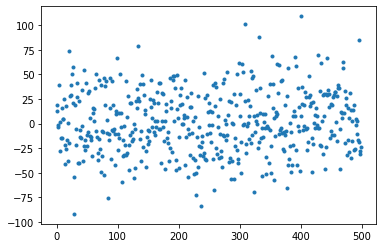

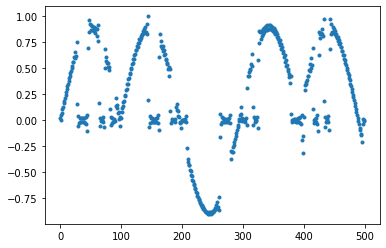

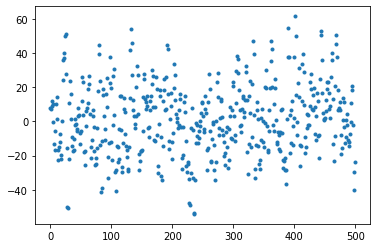

In [ ]:

#tx signal
f0 = 1e+3
Fs_tx = int(200e+3)
Tx_dt = 40.96e-3/2 #Tx random num sequence duration in seconds, nSymbols needs to be below 16777215
sps = 100
n_TxSymbol = int((Fs_tx*Tx_dt)/sps)
num_samples = n_TxSymbol*sps
tx_signal_rand = sig.max_len_seq(24, state=[0,1,1,1,0,0,0,1,1,0,1,0,1,1,1,0,0,0,1,1,0,1,1,0], length=n_TxSymbol)[0]#generate PN code  is this the best way to do it

#do BPSK
t_index = np.linspace(0, Tx_dt, num_samples)
tx_sig_rad = tx_signal_rand*np.pi + np.pi/2
tx_sig_raw2 = np.array([])

for bit in tqdm(tx_sig_rad):
  pulse = np.zeros([sps])
  pulse.fill(bit)
  tx_sig_raw2 = np.concatenate((tx_sig_raw2, pulse))
tx_sig_raw = np.zeros(len(t_index))

for i in range(len(t_index)-1):
  tx_sig_raw[i] = np.cos(2*np.pi*f0*t_index[i]+tx_sig_raw2[i])


#create wave object
tx_sig = Wave(tx_sig_raw, Fs_tx)
tx_sig_raw = None
tx_sig_rad = None
tx_signal_rand = None
tx_sig_raw2 = None


#tag signal
Fs_tag = int(200e+3)
tag_dur = 1.28e-3/2
#tag_dur = Tx_dt/32
print(f"The tag signal is {tag_dur} sec long")
tindex_tag = np.linspace(0, tag_dur, int(tag_dur*Fs_tag))
tag_sig_raw = sig.square(tindex_tag*2*np.pi*10)

num_samples = Fs_tag*tag_dur
bits = [1,1,1,1,1,0,0,1,1,0,1,0,1] # 13 bit long barker code
sps = int(np.floor(num_samples/len(bits)))
print(f"The tag signal has {sps} samples per bit")
pulse_train = np.array([])
for bit in tqdm(bits):
    pulse = np.zeros(sps)
    pulse.fill(bit)
    pulse_train = np.concatenate((pulse_train, pulse)) # add the samples to the signal

tag_sig = Wave(pulse_train, Fs_tag)
pulse_train = None
tag_sig_raw = None
tindex_tag = None

reps_t = 0.5*60*60 #reps in time (sec)
reps = reps_t/Tx_dt
print(f"there are {reps} reps")

rx_sig = combineTagnTxFFT(tag_sig, tx_sig, 200e+3, 1.23456e-6, 0.5e-3)
rx_sig_clean = rx_sig.samples.copy()

rx_sig.samples *= 10 #10 W of output power

dB_FSPL = 100 #Free space path loss
rx_sig.samples *= pow(10, -dB_FSPL/20) #converting FSPL in dB to lin
#rx_sig.samples *= 0.00001

rx_sig.samples *= reps #repetitions in reciever

rx_sig.samples += np.random.normal(loc=0, scale=np.sqrt(reps)*np.sqrt(0.01), size=len(rx_sig.samples)) #adding noise

def lpf(wave, fc, fb): #takes sig, fc and fb in Hz and returns filtered signal
  fc = fc/wave.fs
  fb = fb/wave.fs
  N = 4/fb
  if N%2==1: N+= 1 #force N to be odd
  n = np.arange(N)
  h = np.sinc(2*fc*(n-(N-1)/2)) #build filter
  h *= np.blackman(N) #window
  h /= np.sum(h)
  return sig.convolve(wave.samples, h)[int(N/2):int(-N/2+1)]

plt.figure()
plt.plot(rx_sig.samples[:500], ".")
plt.figure()
plt.plot(rx_sig_clean[:500], ".")
rx_sig.samples = lpf(rx_sig, 40e+3, 10e+3)
plt.figure()
plt.plot(rx_sig.samples[:500], ".")
